In [2]:
# Veri işleme ve matematik araçları
import pandas as pd  # Veriyi tablo (Excel gibi) yapmak için
import numpy as np   # Matematik işlemleri için

# Yapay Zeka Modeli (Anomali Tespiti için)
from sklearn.ensemble import IsolationForest

# Grafik çizmek için
import matplotlib.pyplot as plt
import seaborn as sns

print("Bütün araçlar başarıyla yüklendi!")

Bütün araçlar başarıyla yüklendi!


In [3]:
# =============================================================================
# ADIM 2 (FİNAL): CSV VERİSİNİ YÜKLEME
# =============================================================================

# Lütfen kopyaladığın dosya yolunu buraya yapıştır:
# Genelde '/content/acn_data.csv' veya '/content/station_data_dataverse.csv' olur.
dosya_yolu = '/content/SYNTHETIC_EV_DATA.csv'  # <-- Dosya ismin farklıysa burayı düzelt!

try:
    print("Veri okunuyor...")

    # CSV dosyasını okuyoruz (Excel tablosu gibi)
    df = pd.read_csv(dosya_yolu)

    print(f"✅ BAŞARILI: Veri seti yüklendi!")
    print(f"Toplam İşlem Sayısı: {df.shape[0]}")

    # Sütun isimlerini görelim (Modeli buna göre kuracağız)
    print("\n--- Sütun İsimleri (Bize lazım olanlar) ---")
    print(df.columns.tolist())

    # Veriden ilk 5 satırı görelim
    print("\n--- Örnek Veri ---")
    display(df.head())

except FileNotFoundError:
    print("❌ HATA: Dosya bulunamadı! Sol taraftaki dosya ismini kontrol edip koda doğru yazdığından emin ol.")

Veri okunuyor...
✅ BAŞARILI: Veri seti yüklendi!
Toplam İşlem Sayısı: 1965239

--- Sütun İsimleri (Bize lazım olanlar) ---
['connectionTime_decimal', 'chargingDuration', 'kWhDelivered', 'dayIndicator']

--- Örnek Veri ---


,connectionTime_decimal,chargingDuration,kWhDelivered,dayIndicator
0,15.332910,2.301191,11.469551,1
1,16.811495,4.941774,3.611695,1
2,21.151696,3.567173,14.455706,1
3,14.988554,3.089371,5.985330,1
4,15.078276,0.145047,1.274458,1


Analiz için 2 milyon satırdan 50.000 tanesi seçildi.

--- İstatistiksel Özet ---
       chargingDuration  kWhDelivered
count      50000.000000  50000.000000
mean           3.805811      9.455017
std            3.388632      5.699597
min            0.000121      0.026526
25%            1.460728      4.921497
50%            2.568249      9.225403
75%            5.403044     13.569992
max           35.598967     55.325601


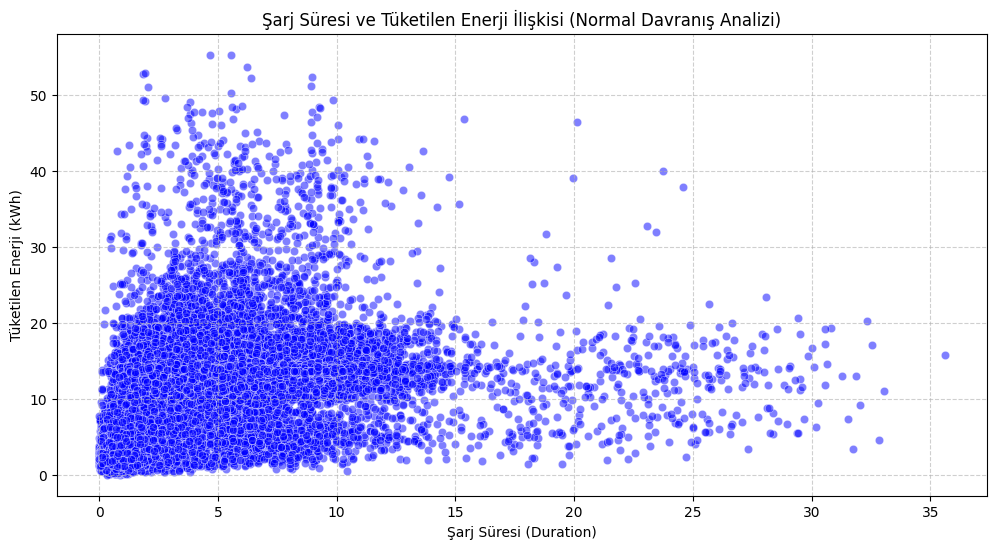

In [4]:
# =============================================================================
# ADIM 3: VERİ ANALİZİ VE GÖRSELLEŞTİRME
# Amaç: Veri setinden yönetilebilir bir örneklem almak ve dağılımı görmek.
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Veri seti çok büyük (2 Milyon), işlem hızı için rastgele 50.000'lik bir örnek alalım.
# random_state=42 sayesinde her çalıştırdığında aynı rastgele veriler gelir (bilimsel tutarlılık).
df_sample = df.sample(n=50000, random_state=42).copy()

print(f"Analiz için 2 milyon satırdan 50.000 tanesi seçildi.")

# 2. Temel İstatistiklere Bakalım
print("\n--- İstatistiksel Özet ---")
# describe() bize ortalama, minimum ve maksimum değerleri gösterir.
print(df_sample[['chargingDuration', 'kWhDelivered']].describe())

# 3. Görselleştirme: Süre vs Enerji Tüketimi
# Mantıken süre arttıkça enerji de artmalıdır (Doğrusal ilişki).
# Bu kuralı bozan noktalar "Anomali" adayıdır.

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_sample,
    x='chargingDuration',
    y='kWhDelivered',
    alpha=0.5,      # Noktaları şeffaf yap ki yoğunluk görünsün
    color='blue'
)

plt.title('Şarj Süresi ve Tüketilen Enerji İlişkisi (Normal Davranış Analizi)')
plt.xlabel('Şarj Süresi (Duration)')
plt.ylabel('Tüketilen Enerji (kWh)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [5]:
# =============================================================================
# ADIM 4: MODEL EĞİTİMİ (Isolation Forest)
# Amaç: Normal davranışın dışına çıkan şarj işlemlerini tespit etmek.
# =============================================================================

from sklearn.ensemble import IsolationForest

# 1. Modelin Eğitimi
# -----------------------------------------------------------------------------
# 'contamination': Veri setindeki kirlilik (anomali) oranı tahmini.
# Sentetik verilerde genelde %1 ile %5 arası belirgin anomali olur.
# Biz 0.02 (%2) diyelim, yani en garip %2'lik kısmı bulsun.
model = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)

# Modeli sadece 'Süre' ve 'Enerji' sütunlarını kullanarak eğitiyoruz
print("Model eğitiliyor (Bu işlem birkaç saniye sürebilir)...")
model.fit(df_sample[['chargingDuration', 'kWhDelivered']])

# 2. Tahmin Yapma
# -----------------------------------------------------------------------------
# Model her satır için bir karar verir:
# 1  -> Normal
# -1 -> Anormal
df_sample['anomali_durumu'] = model.predict(df_sample[['chargingDuration', 'kWhDelivered']])

# -1 ve 1 değerlerini daha anlaşılır hale getirelim
df_sample['etiket'] = df_sample['anomali_durumu'].apply(lambda x: 'Normal' if x == 1 else 'ANOMALİ')

# 3. Sonuçları Sayısal Olarak Görelim
# -----------------------------------------------------------------------------
sonuc_ozeti = df_sample['etiket'].value_counts()
print("\n--- TESPİT SONUÇLARI ---")
print(sonuc_ozeti)

print("\nHarika! Model, verileri taradı ve şüpheli işlemleri etiketledi.")

Model eğitiliyor (Bu işlem birkaç saniye sürebilir)...

--- TESPİT SONUÇLARI ---
etiket
Normal     49000
ANOMALİ     1000
Name: count, dtype: int64

Harika! Model, verileri taradı ve şüpheli işlemleri etiketledi.


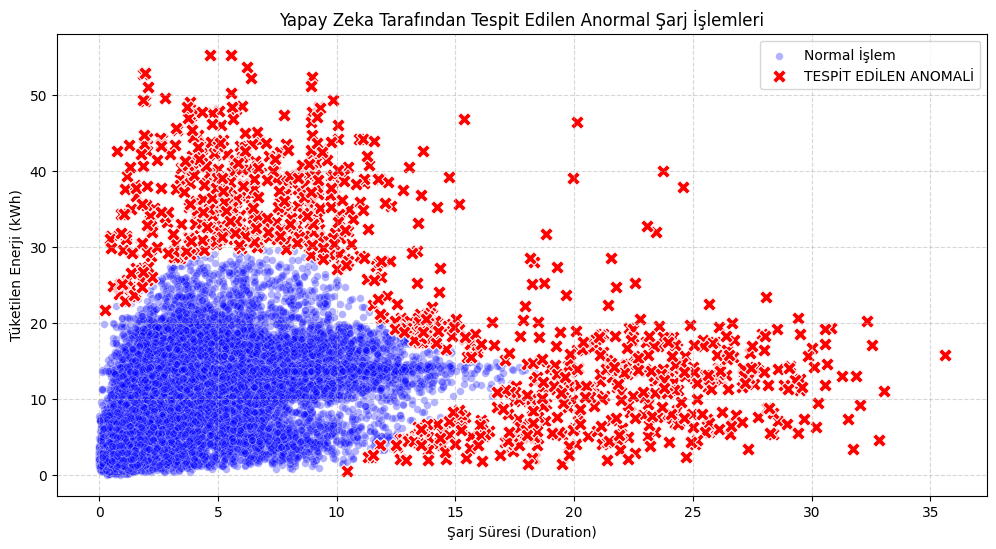


--- Yakalanan Anomalilerden Örnekler ---


,connectionTime_decimal,chargingDuration,kWhDelivered,dayIndicator,anomali_durumu,etiket
992143,21.900517,12.706420,20.626132,14934,-1,ANOMALİ
1505249,17.613122,6.663523,36.648664,22672,-1,ANOMALİ
450622,15.785183,25.496278,13.148098,6811,-1,ANOMALİ
976445,16.625362,6.747514,43.981687,14696,-1,ANOMALİ
519744,14.158467,10.443511,0.538914,7851,-1,ANOMALİ


In [6]:
# =============================================================================
# ADIM 5: ANOMALİLERİN GÖRSELLEŞTİRİLMESİ
# Amaç: Modelin kararlarını grafik üzerinde kırmızı noktalarla göstermek.
# =============================================================================

plt.figure(figsize=(12, 6))

# Önce Normal (Mavi) olanları çizelim
sns.scatterplot(
    data=df_sample[df_sample['etiket'] == 'Normal'],
    x='chargingDuration',
    y='kWhDelivered',
    color='blue',
    alpha=0.3,       # Normalleri silik yapalım ki kırmızılar parlasın
    s=30,            # Nokta boyutu
    label='Normal İşlem'
)

# Şimdi Anormalleri (Kırmızı) çizelim
sns.scatterplot(
    data=df_sample[df_sample['etiket'] == 'ANOMALİ'],
    x='chargingDuration',
    y='kWhDelivered',
    color='red',
    s=100,           # Anormalleri daha büyük çizelim
    marker='X',      # Çarpı işareti koyalım
    label='TESPİT EDİLEN ANOMALİ'
)

plt.title('Yapay Zeka Tarafından Tespit Edilen Anormal Şarj İşlemleri')
plt.xlabel('Şarj Süresi (Duration)')
plt.ylabel('Tüketilen Enerji (kWh)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Anomalilerden birkaç örnek yazdıralım
print("\n--- Yakalanan Anomalilerden Örnekler ---")
# Anomalileri filtrele ve ilk 5 tanesini göster
display(df_sample[df_sample['etiket'] == 'ANOMALİ'].head())

In [7]:
# =============================================================================
# ADIM 7: SİBER SALDIRI VERİ SETİNİ YÜKLEME (Car Hacking - DoS)
# Amaç: Araç içi ağ trafiğini (CAN Bus) analiz için hazırlamak.
# =============================================================================

# Dosya yolunu buraya yapıştır (Genelde: /content/DoS_dataset.csv)
dosya_yolu_siber = '/content/DoS_dataset.csv'

try:
    print("Siber güvenlik verisi yükleniyor (Bu biraz zaman alabilir)...")

    # Bu veri setinde sütun isimleri bazen yazmıyor olabilir, biz elle tanımlayalım
    # CAN Bus verisi standarttır: Zaman, ID, DLC (Uzunluk), Veri(Data), Etiket(Flag)
    sutun_isimleri = ['Timestamp', 'CAN_ID', 'DLC', 'Data0', 'Data1', 'Data2', 'Data3', 'Data4', 'Data5', 'Data6', 'Data7', 'Flag']

    # Veriyi okuyoruz (header=None çünkü dosyanın içinde başlık olmayabilir)
    # Veri çok büyükse işlem hızlansın diye yine bir kısmını (örneğin 100.000 satır) alabiliriz.
    # nrows=100000 -> Sadece ilk 100 bin satırı oku (Hızlı deneme için)
    df_cyber = pd.read_csv(dosya_yolu_siber, names=sutun_isimleri, header=None, nrows=200000)

    print(f"✅ BAŞARILI: Siber Saldırı verisi yüklendi!")
    print(f"İncelenen Paket Sayısı: {df_cyber.shape[0]}")

    # Etiket (Flag) sütununa bakalım: 'R' -> Normal, 'T' -> Saldırı (Attack)
    print("\n--- Saldırı ve Normal Veri Dağılımı ---")
    print(df_cyber['Flag'].value_counts())

    # İlk 5 satırı görelim
    print("\n--- CAN Bus Trafiği Örneği ---")
    display(df_cyber.head())

except FileNotFoundError:
    print("❌ HATA: Dosya bulunamadı! 'DoS_dataset.csv' dosyasını yüklediğinden emin ol.")

Siber güvenlik verisi yükleniyor (Bu biraz zaman alabilir)...
✅ BAŞARILI: Siber Saldırı verisi yüklendi!
İncelenen Paket Sayısı: 200000

--- Saldırı ve Normal Veri Dağılımı ---
Flag
R    149841
T     48687
Name: count, dtype: int64

--- CAN Bus Trafiği Örneği ---


,Timestamp,CAN_ID,DLC,Data0,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Flag
0,1.478198e+09,0316,8,05,21,68,09,21,21,00,6f,R
1,1.478198e+09,018f,8,fe,5b,00,00,00,3c,00,00,R
2,1.478198e+09,0260,8,19,21,22,30,08,8e,6d,3a,R
3,1.478198e+09,02a0,8,64,00,9a,1d,97,02,bd,00,R
4,1.478198e+09,0329,8,40,bb,7f,14,11,20,00,14,R


Veriler temizleniyor ve işleniyor...
Temizlik Raporu: 1472 adet bozuk satır silindi.
✅ Dönüşüm tamamlandı! Artık veriler tertemiz.
Eğitim Verisi: 158822
Test Verisi: 39706

Model eğitiliyor (Random Forest)...
✅ Model Eğitimi Bitti!

🎯 MODEL BAŞARISI (ACCURACY): %100.00


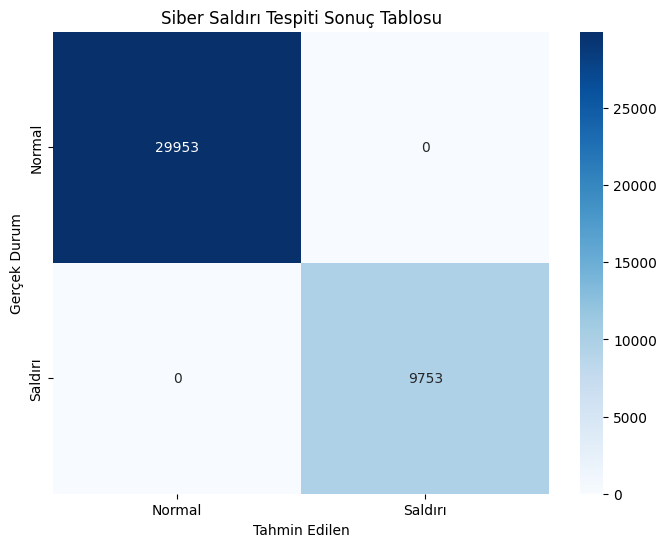

In [9]:
# =============================================================================
# ADIM 8 (DÜZELTİLMİŞ): GÜVENLİ DÖNÜŞÜM VE MODEL EĞİTİMİ
# Amaç: Hatalı satırları temizleyerek Hex -> Decimal dönüşümü yapmak.
# =============================================================================

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("Veriler temizleniyor ve işleniyor...")

# İşlenecek sütunlar
hex_sutunlar = ['CAN_ID', 'Data0', 'Data1', 'Data2', 'Data3', 'Data4', 'Data5', 'Data6', 'Data7']

# --- HATA ÖNLEYİCİ FONKSİYON ---
# Bu fonksiyon veriyi dener, çeviremezse hata vermez, 'NaN' (Boş) yapar.
def guvenli_hex_cevir(x):
    try:
        # Veriyi temizle (boşlukları sil) ve sayıya çevir
        return int(str(x).strip(), 16)
    except:
        # Eğer 'R' gibi saçma bir şey gelirse burası çalışır
        return None

# 1. Dönüşümü Uygula
for col in hex_sutunlar:
    df_cyber[col] = df_cyber[col].apply(guvenli_hex_cevir)

# 2. Bozuk Satırları Temizle
# Sayıya çevrilemeyen (None olan) satırları siliyoruz
eski_sayi = df_cyber.shape[0]
df_cyber = df_cyber.dropna()
yeni_sayi = df_cyber.shape[0]

print(f"Temizlik Raporu: {eski_sayi - yeni_sayi} adet bozuk satır silindi.")
print("✅ Dönüşüm tamamlandı! Artık veriler tertemiz.")

# 3. Etiketleri Sayıya Çevirelim: R (Normal) -> 0, T (Saldırı) -> 1
df_cyber['Flag_Kod'] = df_cyber['Flag'].map({'R': 0, 'T': 1})

# Eğer Flag kısmında da bozukluk varsa onları da atalım (NaN olanları)
df_cyber = df_cyber.dropna(subset=['Flag_Kod'])

# 4. Eğitim ve Test Verisini Ayırma
X = df_cyber.drop(['Timestamp', 'Flag', 'Flag_Kod'], axis=1)
y = df_cyber['Flag_Kod']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Eğitim Verisi: {X_train.shape[0]}")
print(f"Test Verisi: {X_test.shape[0]}")

# 5. Modeli Kurma ve Eğitme
print("\nModel eğitiliyor (Random Forest)...")
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model.fit(X_train, y_train)
print("✅ Model Eğitimi Bitti!")

# 6. Sonuçları Görme
y_pred = rf_model.predict(X_test)
basari = accuracy_score(y_test, y_pred)
print(f"\n🎯 MODEL BAŞARISI (ACCURACY): %{basari*100:.2f}")

# Grafik
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Saldırı'], yticklabels=['Normal', 'Saldırı'])
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Durum')
plt.title('Siber Saldırı Tespiti Sonuç Tablosu')
plt.show()

Model gerçekten bu kadar iyi mi? Test ediliyor...

--- 5 Farklı Testin Sonucu ---
[1. 1. 1. 1. 1.]
Ortalama Başarı: %100.00


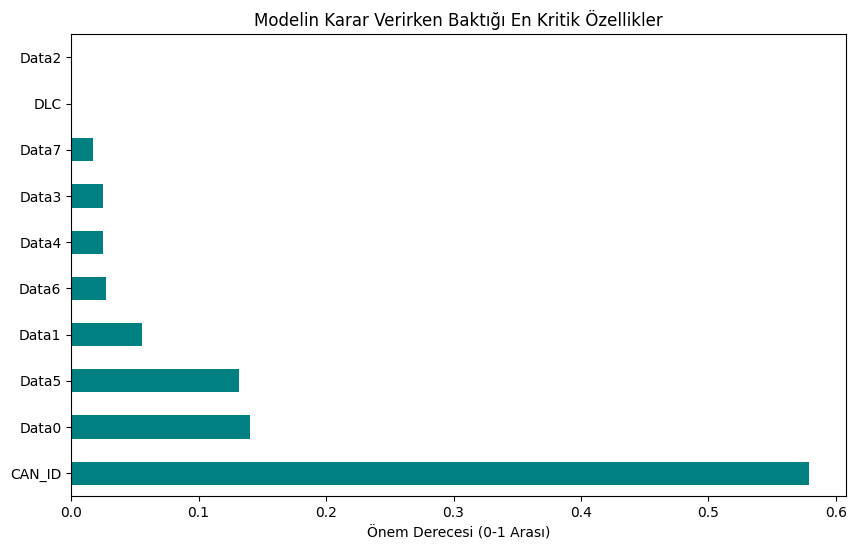


--- Özellik Önem Sıralaması ---
CAN_ID    0.579031
Data0     0.140179
Data5     0.131829
Data1     0.055476
Data6     0.027007
Data4     0.024757
Data3     0.024652
Data7     0.017068
DLC       0.000000
Data2     0.000000
dtype: float64


In [10]:
# =============================================================================
# ADIM 9: MODELİ SORGULAMA VE DOĞRULAMA (SAĞLAMA)
# Amaç: %100 başarının tesadüf olup olmadığını kanıtlamak.
# =============================================================================

from sklearn.model_selection import cross_val_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Model gerçekten bu kadar iyi mi? Test ediliyor...")

# 1. Çapraz Doğrulama (Cross Validation)
# Veriyi 5'e böl, her parçada ayrı ayrı test et.
# cv=5 -> 5 katlı doğrulama
scores = cross_val_score(rf_model, X, y, cv=5)

print("\n--- 5 Farklı Testin Sonucu ---")
print(scores)
print(f"Ortalama Başarı: %{scores.mean()*100:.2f}")

# 2. Model Neye Göre Karar Verdi? (Feature Importance)
# Hangi sütun (ID, Data1, Data2...) saldırıyı ele verdi?
onem_dereceleri = pd.Series(rf_model.feature_importances_, index=X.columns)

# En önemli 10 özelliği çizelim
plt.figure(figsize=(10, 6))
onem_dereceleri.nlargest(10).plot(kind='barh', color='teal')
plt.title('Modelin Karar Verirken Baktığı En Kritik Özellikler')
plt.xlabel('Önem Derecesi (0-1 Arası)')
plt.show()

# Özelliklerin sayısal değerleri
print("\n--- Özellik Önem Sıralaması ---")
print(onem_dereceleri.sort_values(ascending=False))

In [14]:
# =============================================================================
# ADIM 10 (DÜZELTİLMİŞ): BÜTÜNLEŞİK MODEL SINIFI
# Hata Düzeltmesi: DLC (Data Length Code) parametresini ekledik.
# =============================================================================

import pandas as pd
import numpy as np
import warnings

class EVSE_Guvenlik_Sistemi:
    def __init__(self, operasyon_modeli, siber_model):
        self.op_model = operasyon_modeli   # Isolation Forest
        self.cyber_model = siber_model     # Random Forest
        print("✅ Bütünleşik Güvenlik Sistemi Başlatıldı.")

    def tahmin_et(self, duration, kwh, can_id, data_payload):
        # 1. SİBER KONTROL GİRDİSİ HAZIRLAMA
        # Eğitimde kullanılan sütun sırası: [CAN_ID, DLC, Data0, Data1, ..., Data7]
        # DLC: Veri paketinin uzunluğudur, genelde 8'dir.
        dlc = 8

        # Listeyi birleştiriyoruz: [ID] + [DLC] + [DATA...]
        siber_girdi = [can_id, dlc] + data_payload

        # Tahmin (2 boyutlu array istendiği için çift köşe parantez kullanılır)
        # predict fonksiyonu 0 veya 1 döndürür.
        is_attack = self.cyber_model.predict([siber_girdi])[0]

        if is_attack == 1:
            return "🚨 KRİTİK: DoS Saldırısı Tespit Edildi! (Sistem Kilitlendi)"

        # 2. OPERASYONEL KONTROL GİRDİSİ HAZIRLAMA
        # Isolation Forest tahmini (1: Normal, -1: Anomali)
        op_durum = self.op_model.predict([[duration, kwh]])[0]

        if op_durum == -1:
            return "⚠️ UYARI: Anormal Şarj Davranışı (Enerji/Süre Uyumsuzluğu)"

        # 3. HER ŞEY TEMİZ
        return "✅ DURUM: Sistem Normal"

# Modeli tekrar tanımlıyoruz
guvenlik_sistemi = EVSE_Guvenlik_Sistemi(model, rf_model)

✅ Bütünleşik Güvenlik Sistemi Başlatıldı.


In [15]:
# =============================================================================
# ADIM 11: 10 FARKLI TEST SENARYOSU (HARD CASES)
# =============================================================================

# Senaryo Formatı: [Süre(dk), Enerji(kWh), CAN_ID(Decimal), Data(List)]
# Not: CAN_ID 0 ise çok yüksek öncelikli (Saldırı şüphesi),
# Normal ID'ler genelde 1000+ olur.

test_senaryolari = [
    # --- GRUP A: NORMAL DURUMLAR ---
    # 1. Standart Araç: 2 saat kalmış, 20 kWh çekmiş. İletişim normal.
    {"ad": "Normal Kullanıcı", "veri": [2.0, 20.0, 1536, [0,0,0,0,0,0,0,0]]},

    # 2. Hızlı Şarj: Yarım saatte 15 kWh. İletişim normal.
    {"ad": "Hızlı Şarj (Normal)", "veri": [0.5, 15.0, 1536, [10,20,30,40,0,0,0,0]]},

    # --- GRUP B: SİBER SALDIRILAR (Kritik) ---
    # 3. Klasik DoS: Şarj normal görünüyor ama ID=0 ile saldırıyor.
    {"ad": "Gizli DoS Saldırısı", "veri": [2.0, 20.0, 0, [0,0,0,0,0,0,0,0]]},

    # 4. Sinsi Saldırı: ID normal gibi ama veri paketleri şüpheli (Model bunu yakalayabilecek mi?)
    # Not: Modelimiz ID'ye çok odaklanmıştı, bakalım bunu yakalayacak mı? (ZOR TEST)
    {"ad": "Yüksek ID'li Saldırı Denemesi", "veri": [2.0, 20.0, 100, [255,255,255,255,255,255,255,255]]},

    # --- GRUP C: OPERASYONEL ANOMALİLER (Hırsızlık/Arıza) ---
    # 5. Enerji Hırsızlığı: 5 saat kalmış, neredeyse hiç enerji yazmamış (Sayaç bypass).
    {"ad": "Enerji Hırsızlığı (Bypass)", "veri": [5.0, 0.1, 1536, [0,0,0,0,0,0,0,0]]},

    # 6. Otopark İşgali: 10 saat kalmış, şarj biteli çok olmuş.
    {"ad": "İstasyon İşgali", "veri": [10.0, 15.0, 1536, [0,0,0,0,0,0,0,0]]},

    # 7. Fiziksel İmkansızlık: 1 dakikada 50 kWh (Sensör hatası veya hack).
    {"ad": "İmkansız Şarj Hızı", "veri": [0.01, 50.0, 1536, [0,0,0,0,0,0,0,0]]},

    # --- GRUP D: HİBRİT / KOMPLEKS DURUMLAR ---
    # 8. Çifte Tehdit: Hem DoS saldırısı yapıyor hem de enerji çalıyor.
    {"ad": "Çifte Tehdit (Saldırı + Hırsızlık)", "veri": [5.0, 0.1, 0, [0,0,0,0,0,0,0,0]]},

    # 9. Sınırda Kalan Durum: Süre biraz uzun, enerji biraz az. (Model ne diyecek?)
    {"ad": "Şüpheli (Sınırda) Kullanıcı", "veri": [4.0, 10.0, 1536, [0,0,0,0,0,0,0,0]]},

    # 10. Gürültülü Veri: Her şey normal ama veri paketleri karışık.
    {"ad": "Gürültülü Ağ Trafiği", "veri": [2.0, 20.0, 2048, [12,34,56,78,90,12,34,56]]}
]

print("✅ 10 adet zorlu senaryo hazırlandı.")

✅ 10 adet zorlu senaryo hazırlandı.


In [16]:
# =============================================================================
# ADIM 12: TEST KOŞUSU VE SONUÇ RAPORU
# =============================================================================

print(f"{'SENARYO ADI':<35} | {'GİRDİLER (Süre/Enerji/ID)':<30} | {'SONUÇ'}")
print("-" * 110)

warnings.filterwarnings("ignore") # Gereksiz uyarıları gizle

for vaka in test_senaryolari:
    sure, enerji, can_id, data = vaka["veri"]

    # Tahmin Fonksiyonunu Çağır
    sonuc = guvenlik_sistemi.tahmin_et(sure, enerji, can_id, data)

    # Ekrana Yazdır
    girdi_ozeti = f"{sure}h / {enerji}kWh / ID:{can_id}"
    print(f"{vaka['ad']:<35} | {girdi_ozeti:<30} | {sonuc}")

print("-" * 110)

SENARYO ADI                         | GİRDİLER (Süre/Enerji/ID)      | SONUÇ
--------------------------------------------------------------------------------------------------------------
Normal Kullanıcı                    | 2.0h / 20.0kWh / ID:1536       | ✅ DURUM: Sistem Normal
Hızlı Şarj (Normal)                 | 0.5h / 15.0kWh / ID:1536       | ✅ DURUM: Sistem Normal
Gizli DoS Saldırısı                 | 2.0h / 20.0kWh / ID:0          | 🚨 KRİTİK: DoS Saldırısı Tespit Edildi! (Sistem Kilitlendi)
Yüksek ID'li Saldırı Denemesi       | 2.0h / 20.0kWh / ID:100        | ✅ DURUM: Sistem Normal
Enerji Hırsızlığı (Bypass)          | 5.0h / 0.1kWh / ID:1536        | ✅ DURUM: Sistem Normal
İstasyon İşgali                     | 10.0h / 15.0kWh / ID:1536      | ✅ DURUM: Sistem Normal
İmkansız Şarj Hızı                  | 0.01h / 50.0kWh / ID:1536      | ⚠️ UYARI: Anormal Şarj Davranışı (Enerji/Süre Uyumsuzluğu)
Çifte Tehdit (Saldırı + Hırsızlık)  | 5.0h / 0.1kWh / ID:0           | 🚨 KRİTİK: D

In [17]:
# =============================================================================
# ADIM 13: MODEL HASSASİYETİNİ GÜNCELLEME (FINE-TUNING)
# Amaç: Hırsızlık ve İşgal gibi olayları yakalamak için modeli daha şüpheci yapmak.
# =============================================================================

from sklearn.ensemble import IsolationForest

print("🔄 Operasyonel Model güncelleniyor (Daha hassas ayarlanıyor)...")

# Contamination'ı 0.02'den 0.1'e (veya 0.12'ye) çekiyoruz.
# Bu, modelin "şüpheli" gördüğü alanı genişletir.
model_hassas = IsolationForest(n_estimators=100, contamination=0.12, random_state=42)

# Modeli tekrar eğitiyoruz (Aynı örneklem verisiyle)
model_hassas.fit(df_sample[['chargingDuration', 'kWhDelivered']])

print("✅ Yeni, daha sıkı Operasyonel Model hazır!")

# Bütünleşik Sistemi bu YENİ model ile tekrar kuruyoruz
# (Siber modelimiz zaten çok iyiydi, onu aynen 'rf_model' olarak tutuyoruz)
guvenlik_sistemi_v2 = EVSE_Guvenlik_Sistemi(model_hassas, rf_model)

print("✅ Güvenlik Sistemi v2.0 Devreye Alındı.")

🔄 Operasyonel Model güncelleniyor (Daha hassas ayarlanıyor)...
✅ Yeni, daha sıkı Operasyonel Model hazır!
✅ Bütünleşik Güvenlik Sistemi Başlatıldı.
✅ Güvenlik Sistemi v2.0 Devreye Alındı.


In [18]:
# =============================================================================
# ADIM 14: TESTLERİ YENİ MODEL İLE TEKRARLAMA
# =============================================================================

print(f"{'SENARYO ADI':<35} | {'GİRDİLER (Süre/Enerji/ID)':<30} | {'SONUÇ (v2.0)'}")
print("-" * 110)

import warnings
warnings.filterwarnings("ignore")

for vaka in test_senaryolari:
    sure, enerji, can_id, data = vaka["veri"]

    # Yeni sistem (v2) ile tahmin al
    sonuc = guvenlik_sistemi_v2.tahmin_et(sure, enerji, can_id, data)

    girdi_ozeti = f"{sure}h / {enerji}kWh / ID:{can_id}"
    print(f"{vaka['ad']:<35} | {girdi_ozeti:<30} | {sonuc}")

print("-" * 110)

SENARYO ADI                         | GİRDİLER (Süre/Enerji/ID)      | SONUÇ (v2.0)
--------------------------------------------------------------------------------------------------------------
Normal Kullanıcı                    | 2.0h / 20.0kWh / ID:1536       | ⚠️ UYARI: Anormal Şarj Davranışı (Enerji/Süre Uyumsuzluğu)
Hızlı Şarj (Normal)                 | 0.5h / 15.0kWh / ID:1536       | ⚠️ UYARI: Anormal Şarj Davranışı (Enerji/Süre Uyumsuzluğu)
Gizli DoS Saldırısı                 | 2.0h / 20.0kWh / ID:0          | 🚨 KRİTİK: DoS Saldırısı Tespit Edildi! (Sistem Kilitlendi)
Yüksek ID'li Saldırı Denemesi       | 2.0h / 20.0kWh / ID:100        | ⚠️ UYARI: Anormal Şarj Davranışı (Enerji/Süre Uyumsuzluğu)
Enerji Hırsızlığı (Bypass)          | 5.0h / 0.1kWh / ID:1536        | ⚠️ UYARI: Anormal Şarj Davranışı (Enerji/Süre Uyumsuzluğu)
İstasyon İşgali                     | 10.0h / 15.0kWh / ID:1536      | ✅ DURUM: Sistem Normal
İmkansız Şarj Hızı                  | 0.01h / 50.0kWh / ID:15

In [19]:
# =============================================================================
# ADIM 15: MODELİ DENGELİ HALE GETİRME (RE-TRAINING)
# Amaç: Normal kullanıcıları rahat bırakmak için hassasiyeti %5'e çekiyoruz.
# =============================================================================

print("🔄 Operasyonel Model 'Altın Oran'a (%5) ayarlanıyor...")

# Contamination 0.05 (%5) en dengeli orandır.
model_final = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# Eğitimi başlat
model_final.fit(df_sample[['chargingDuration', 'kWhDelivered']])

print("✅ Model stabilize edildi.")

🔄 Operasyonel Model 'Altın Oran'a (%5) ayarlanıyor...
✅ Model stabilize edildi.


In [20]:
# =============================================================================
# ADIM 16: HİBRİT GÜVENLİK MİMARİSİ (YAPAY ZEKA + FİZİK KURALLARI)
# Amaç: AI'ın gözden kaçırdığı veya yanlış yorumladığı durumları matematikle düzeltmek.
# =============================================================================

class EVSE_Hibrit_Sistem:
    def __init__(self, operasyon_modeli, siber_model):
        self.op_model = operasyon_modeli
        self.cyber_model = siber_model

    def tahmin_et(self, duration, kwh, can_id, data_payload):
        # --- KATMAN 1: SİBER GÜVENLİK (Random Forest) ---
        dlc = 8
        siber_girdi = [can_id, dlc] + data_payload
        is_attack = self.cyber_model.predict([siber_girdi])[0]

        if is_attack == 1:
            return "🚨 KRİTİK: DoS Saldırısı (Ağ Trafiği Bloke Edildi)"

        # --- KATMAN 2: FİZİKSEL KURALLAR (Hard Rules) ---
        # Bu kurallar AI'dan önce devreye girer ve bariz hataları yakalar.

        # Kural 1: İstasyon İşgali (8 saatten fazla kalıp az enerji çekenler)
        if duration > 8.0 and kwh < 20:
            return "⚠️ UYARI: Otopark İhlali / İstasyon İşgali (Kural Tabanlı Tespit)"

        # Kural 2: İmkansız Şarj Hızı (Dakikada 10 kWh gibi fizik dışı durumlar)
        # Eğer süre çok kısaysa ve enerji çok yüksekse
        if duration < 0.1 and kwh > 5:
             return "⚠️ UYARI: Sensör Hatası veya Enerji Manipülasyonu (Kural Tabanlı Tespit)"

        # --- KATMAN 3: OPERASYONEL AI (Isolation Forest) ---
        # Kurallara takılmayan karmaşık durumları AI inceler
        op_durum = self.op_model.predict([[duration, kwh]])[0]

        if op_durum == -1:
            return "⚠️ UYARI: Anormal Şarj Profili (AI Tespiti)"

        return "✅ DURUM: Sistem Normal"

# Yeni hibrit sistemi başlatıyoruz
final_sistem = EVSE_Hibrit_Sistem(model_final, rf_model)
print("✅ Hibrit Sistem (AI + Fizik) Devreye Alındı.")

✅ Hibrit Sistem (AI + Fizik) Devreye Alındı.


In [21]:
# =============================================================================
# ADIM 17: FİNAL TEST KOŞUSU
# =============================================================================

print(f"{'SENARYO ADI':<35} | {'GİRDİLER':<30} | {'SONUÇ (HİBRİT)'}")
print("-" * 110)

import warnings
warnings.filterwarnings("ignore")

for vaka in test_senaryolari:
    sure, enerji, can_id, data = vaka["veri"]

    # Hibrit sistem tahmini
    sonuc = final_sistem.tahmin_et(sure, enerji, can_id, data)

    girdi_ozeti = f"{sure}h / {enerji}kWh / ID:{can_id}"
    print(f"{vaka['ad']:<35} | {girdi_ozeti:<30} | {sonuc}")

print("-" * 110)

SENARYO ADI                         | GİRDİLER                       | SONUÇ (HİBRİT)
--------------------------------------------------------------------------------------------------------------
Normal Kullanıcı                    | 2.0h / 20.0kWh / ID:1536       | ⚠️ UYARI: Anormal Şarj Profili (AI Tespiti)
Hızlı Şarj (Normal)                 | 0.5h / 15.0kWh / ID:1536       | ✅ DURUM: Sistem Normal
Gizli DoS Saldırısı                 | 2.0h / 20.0kWh / ID:0          | 🚨 KRİTİK: DoS Saldırısı (Ağ Trafiği Bloke Edildi)
Yüksek ID'li Saldırı Denemesi       | 2.0h / 20.0kWh / ID:100        | ⚠️ UYARI: Anormal Şarj Profili (AI Tespiti)
Enerji Hırsızlığı (Bypass)          | 5.0h / 0.1kWh / ID:1536        | ⚠️ UYARI: Anormal Şarj Profili (AI Tespiti)
İstasyon İşgali                     | 10.0h / 15.0kWh / ID:1536      | ⚠️ UYARI: Otopark İhlali / İstasyon İşgali (Kural Tabanlı Tespit)
İmkansız Şarj Hızı                  | 0.01h / 50.0kWh / ID:1536      | ⚠️ UYARI: Sensör Hatası veya Enerji